In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from scipy.stats import gaussian_kde
from scipy.stats import norm
from scipy import integrate
from sklearn.neighbors import KernelDensity
import scipy.stats

np.random.seed(20200619)

lab_ranges = {'ALBUMIN':        [3.5, 5.5],                
              'BICARBONATE':    [21,29],                     
              'BUN':            [10,20],                                          
              'CALCIUM':        [8.5,10.5],                                       
              'FREECALCIUM':    [1.05,1.37],                  
              'CHLORIDE':       [98,106],                       
              'MAGNESIUM':      [1.8,3],                   
              'PHOSPHATE':      [3,4.5],                     
              'HEMOGLOBIN':     [12,18],                   
              'SODIUM':         [136,145],                
              'CREATININE':     [0.5,1.5],                   
              'PLATELET':       [150,400],                  
              'POTASSIUM':      [3.3,5.5],                 
              'LACTATE':        [0.5,2.0],                      
              'WBC':            [4.5,11],                     
              'GLUCOSE':        [75.0, 115.0]            
             } 

lab_unit = {  'ALBUMIN':        'g/dL',          
              'BICARBONATE':    'mEq/L',           
              'BUN':            'mg/dL',                           
              'CALCIUM':        'mg/dL',                                
              'FREECALCIUM':    'mmol/L',        
              'CHLORIDE':       'mEq/L',             
              'MAGNESIUM':      'mg/dL',         
              'PHOSPHATE':      'mg/dL',           
              'HEMOGLOBIN':     'g/dL',          
              'SODIUM':         'mEq/L',        
              'CREATININE':     'mg/dL',           
              'PLATELET':       'K/uL',            
              'POTASSIUM':      'mEq/L',         
              'LACTATE':        'mmol/L',            
              'WBC':            'K/uL',            
              'GLUCOSE':        'mg/dL'         
             } 


data = pd.read_csv("S:/NUS/Year Two/UROPS/eicu_labminmax.csv")

mort_data = data[data['mort_icu']==1]
surv_data = data[data['mort_icu']==0]


In [4]:
def ResumeNorm(val1, val2):
    norm_val1 = norm.ppf(0.025)
    norm_val2 = norm.ppf(0.975)
    mean = (val2 - val1)/2 + val1
    scale = (val1 - val2) / (norm_val1 - norm_val2)
    return norm(mean, scale)

def OverlapParam(dist1, dist2):
    """
        Overlapping coefficient: integration of min value of two distribution over R. 
        For chloride, glucose, sodium, use large interval with focus point interval instead. 
    """
    func = lambda x: min(dist1.pdf(x), dist2.pdf(x))
    return integrate.quad(func, -np.inf , np.inf)

def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

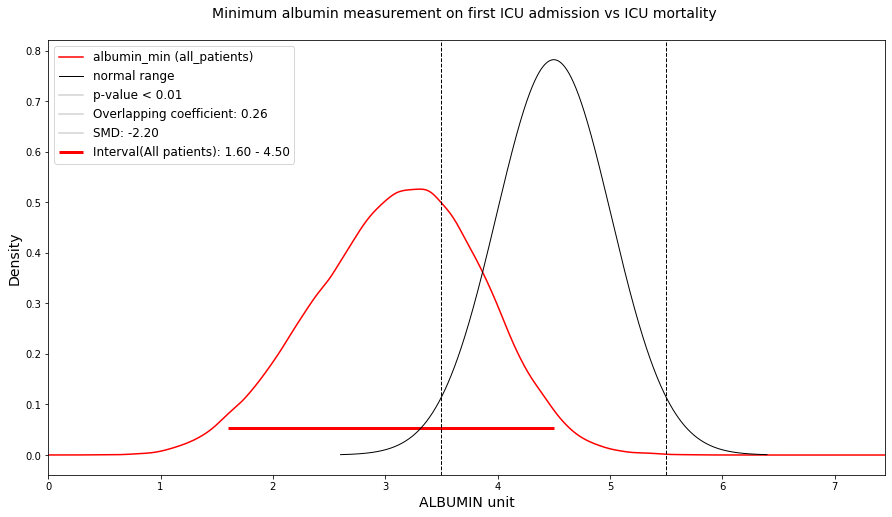

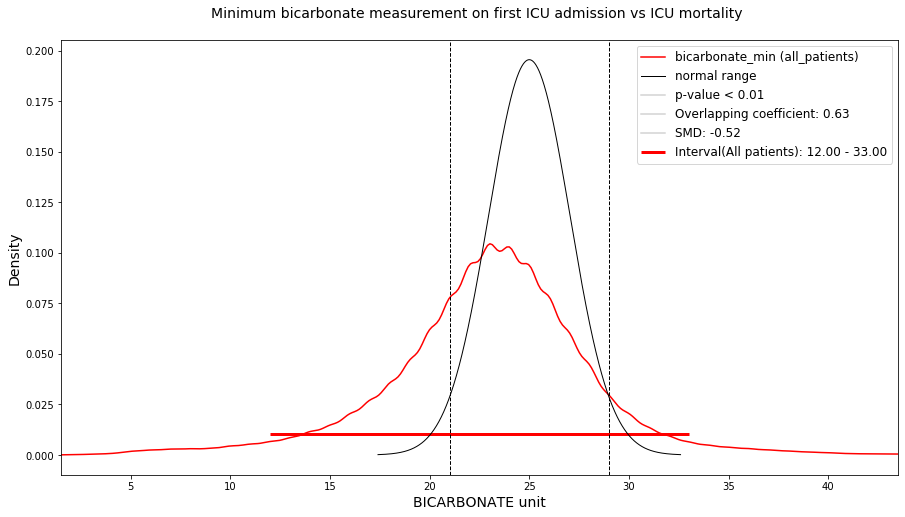

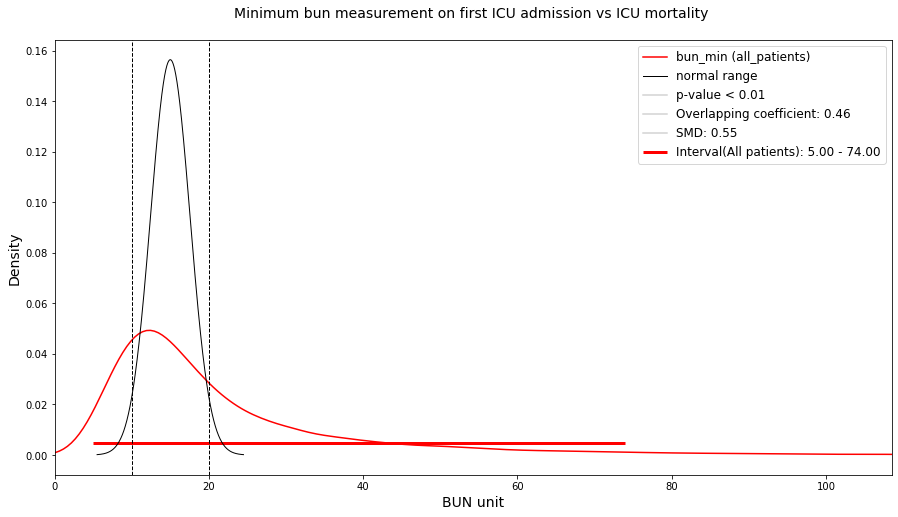

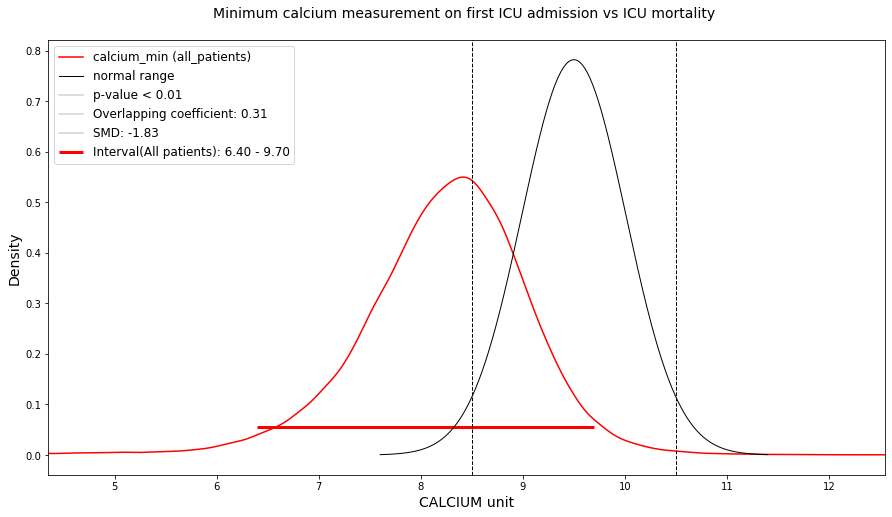

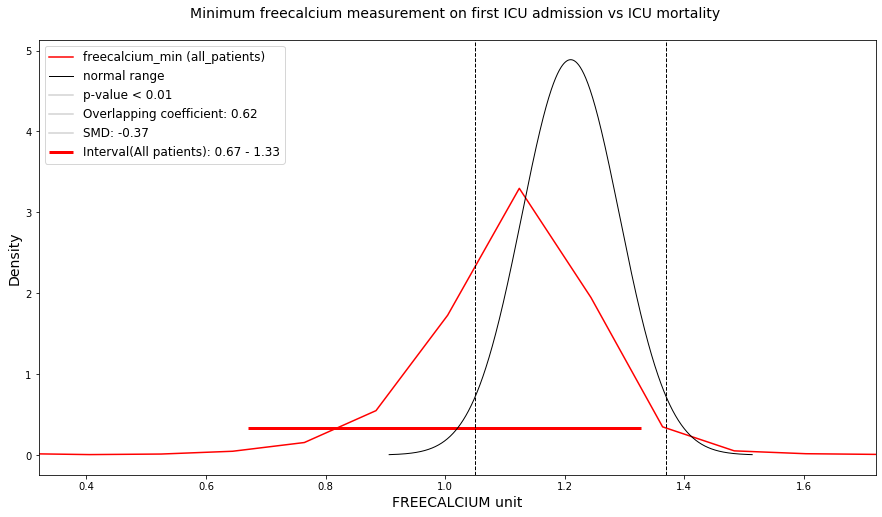

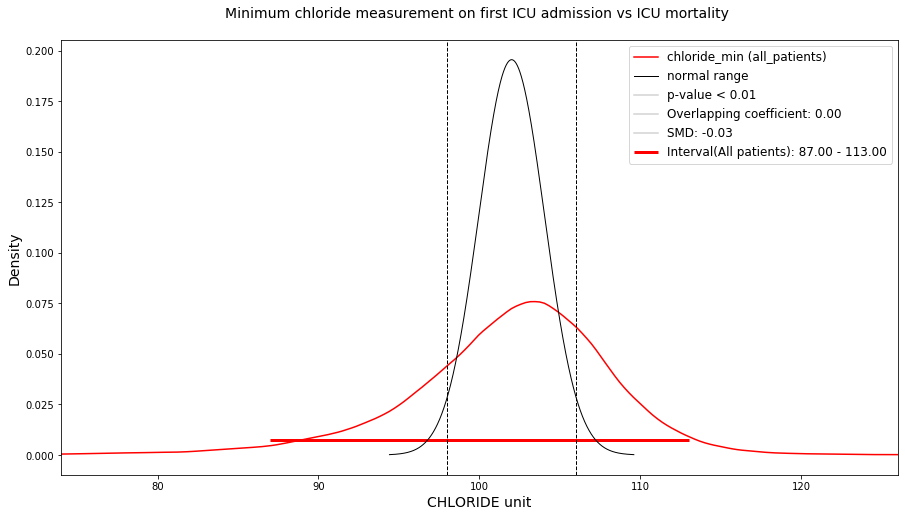

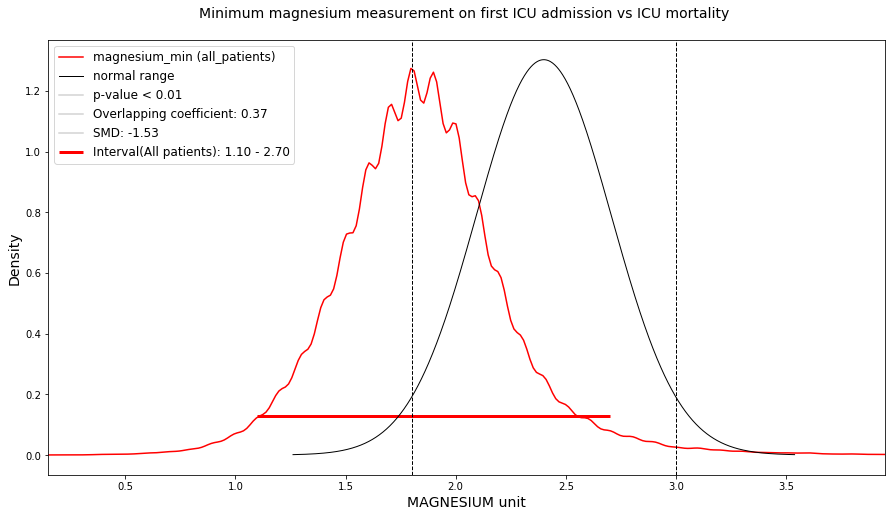

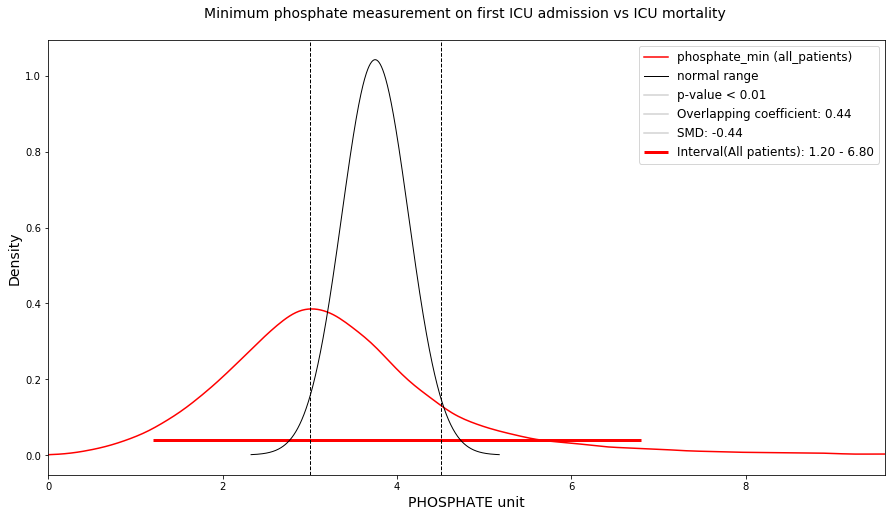

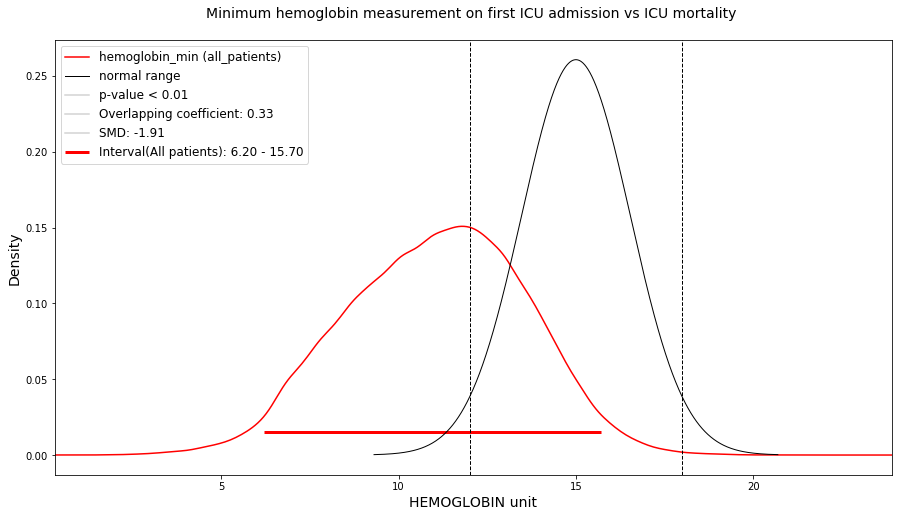

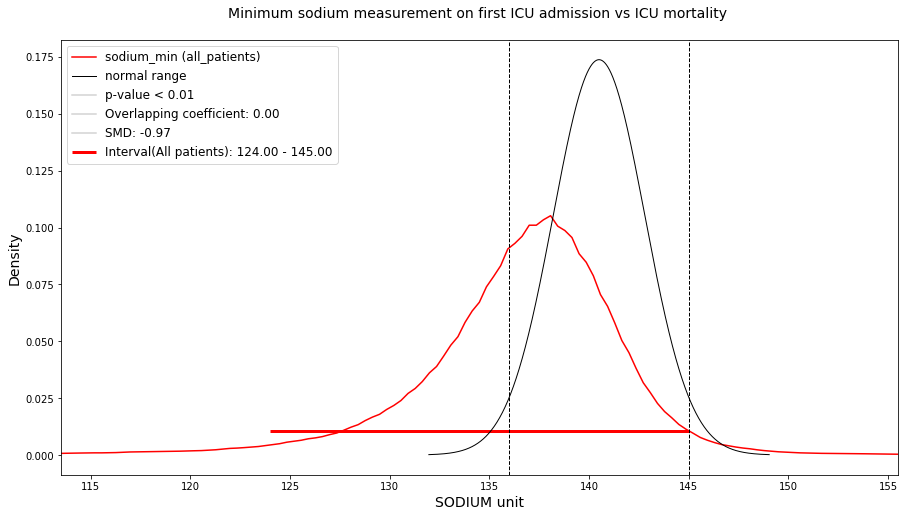

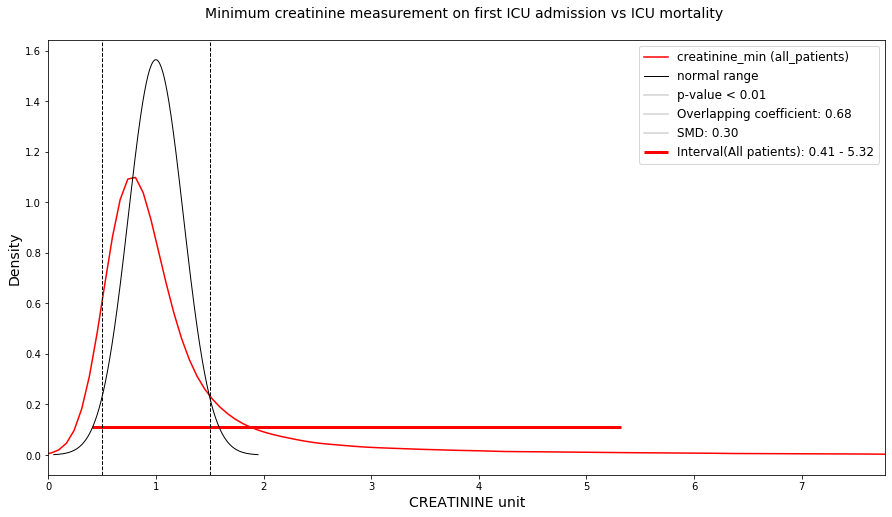

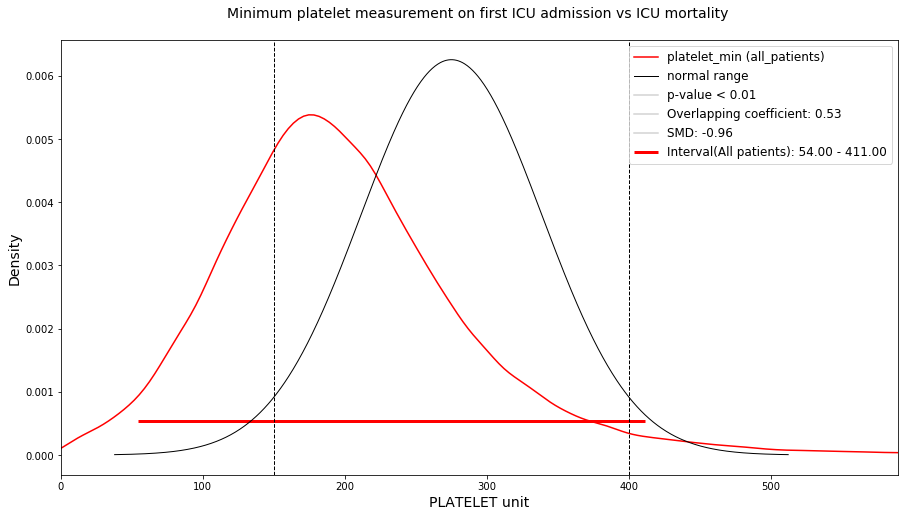

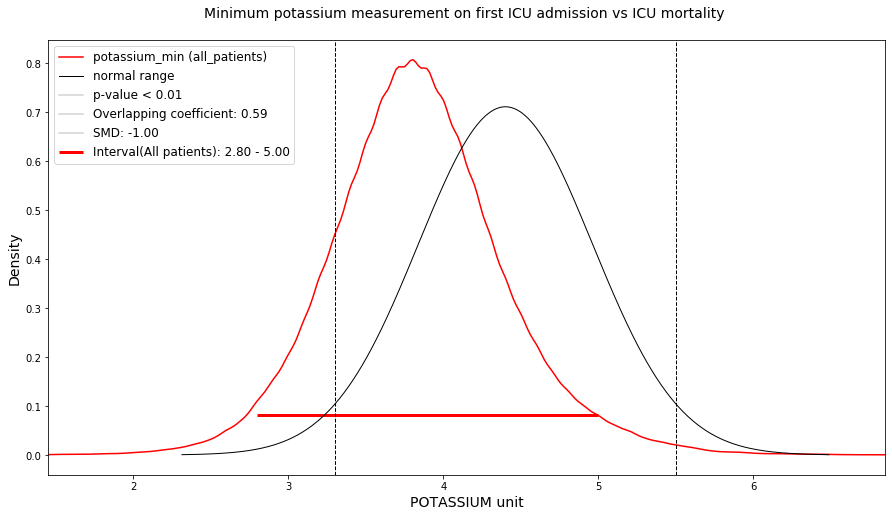

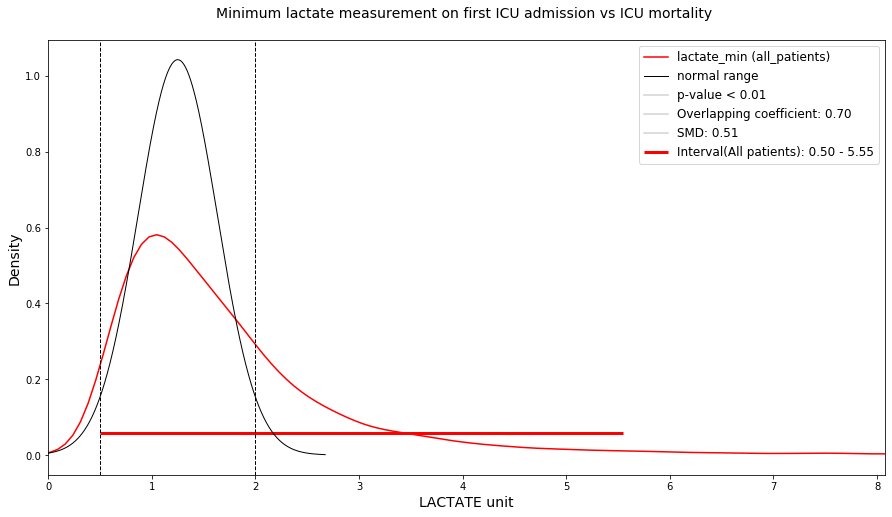

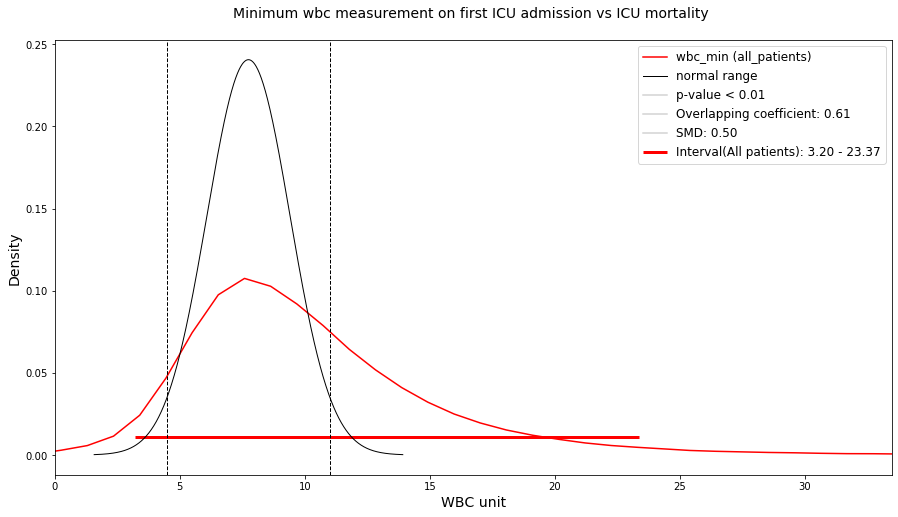

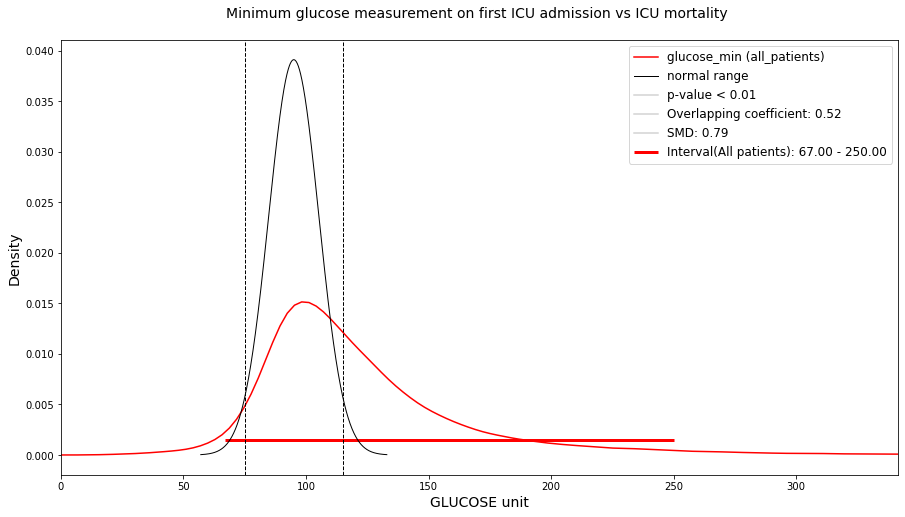

In [5]:
#MIN 

for i, u in iter(lab_unit.items()):
    
    
    
    fig, ax = plt.subplots(figsize=(15,8))
    
    #plot best out come dist
    n_surv = surv_data[i.lower() + '_min'].dropna().count()
    n_all = data[i.lower() + '_min'].dropna().count()
    quarter = n_surv /4
    quarter = int(quarter)
    cond = data.mort_icu == 0
    all_patients = surv_data.sort_values(by=['los'])[i.lower()+'_min'].dropna()
    
    [q1, q2] = all_patients.quantile(q = [0.025,0.975])
    
    #best_group = best_group[best_group > q1]
    #best_group = best_group[best_group < q2]

    #range for x and y
    plot_range = [min(q1,lab_ranges[i][0]),max(q2,lab_ranges[i][1])]
    diff = plot_range[1] - plot_range[0]
    #plt.xlim(max(plot_range[0] - 0.5*diff, 0), plot_range[1] + 0.5*diff)
    
    all_patients.plot.kde(color='r', label=i.lower()+'_min (all_patients)', xlim= (max(plot_range[0] - 0.5*diff, 0), plot_range[1] + 0.5*diff))
    
    xs = np.linspace(plot_range[0], plot_range[1], 600)
    density = gaussian_kde(all_patients)
    ys = density(xs)
    index = np.argmax(ys)
    maxy = ys[index]
  
    #plot best outcome interval
    #interval line
    plt.hlines(y=0.1*maxy, xmin = q1, xmax = q2, linewidth=3, linestyle='-', color='r', label='Interval(All patients): {} - {}'.format(format(q1,'.2f'), format(q2,'.2f')))
    
    # plot normal range 
    plt.axvline(x=lab_ranges[i][0], linewidth=1, linestyle='--', color='k')
    plt.axvline(x=lab_ranges[i][1], linewidth=1, linestyle='--', color='k')
    
    
    # plot normal distribution with normal range
    norm_dist = ResumeNorm(lab_ranges[i][0], lab_ranges[i][1])
    x = np.linspace(norm_dist.ppf(0.0001),norm_dist.ppf(0.9999), 1000)
    ax.plot(x, norm_dist.pdf(x), 'k-',#color 'r-' red 'k-' black
            lw=1,#linewidth
            alpha=1,#RGBA transparency
            linestyle='-',
            label='normal range')
    ax.legend(loc='best', frameon=False)
    
    #MannWhitney test
    norm_sample = norm_dist.rvs(size=n_all, random_state=20200620)
    t_stat, p_val = mannwhitneyu(norm_sample, all_patients)
    
    #standardized mean difference
    smd = cohen_d(all_patients, norm_sample)
        
    #overlapping parameter
    all_patients_dist = gaussian_kde(all_patients)
    ovl = OverlapParam(all_patients_dist, norm_dist)
        
    if p_val < 0.01:
        plt.plot([], label='p-value < 0.01', color='lightgrey')
    else:
        plt.plot([], label='p-value: {}'.format(format(p_val, '.2f')), color='lightgrey')
    plt.plot([], label='Overlapping coefficient: {}'.format(format(max(ovl), '.2f')), color='lightgrey')
    plt.plot([], label='SMD: {}'.format(format(smd, '.2f')), color='lightgrey')
    
    plt.title('Minimum {} measurement on first ICU admission '.format(i.lower()) +
                   'vs ICU mortality \n', fontsize=14)
    plt.xlabel(i + ' ' + 'unit', fontsize=14)
    plt.ylabel("Density", fontsize=14)
    plt.legend(fontsize=12)
    plt.savefig("eicu_figure/2group/all_patients/ALL_{}_MIN.png".format(i))
    plt.show()
    


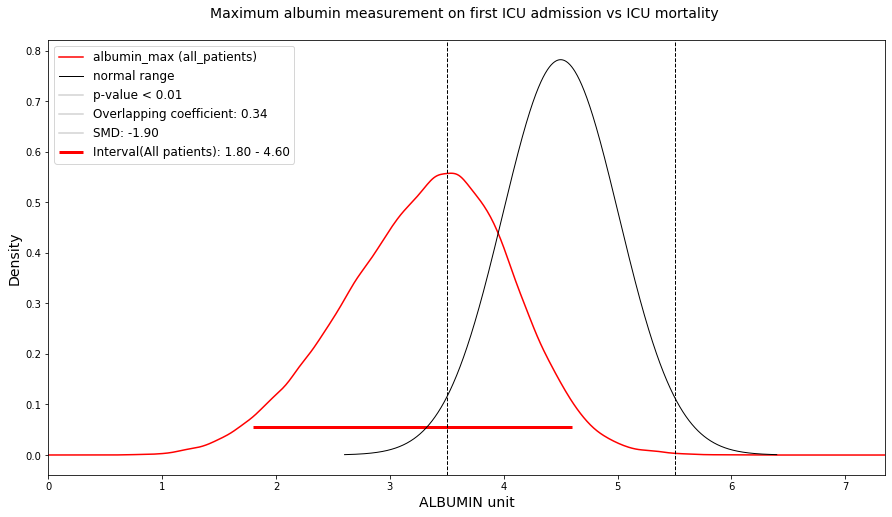

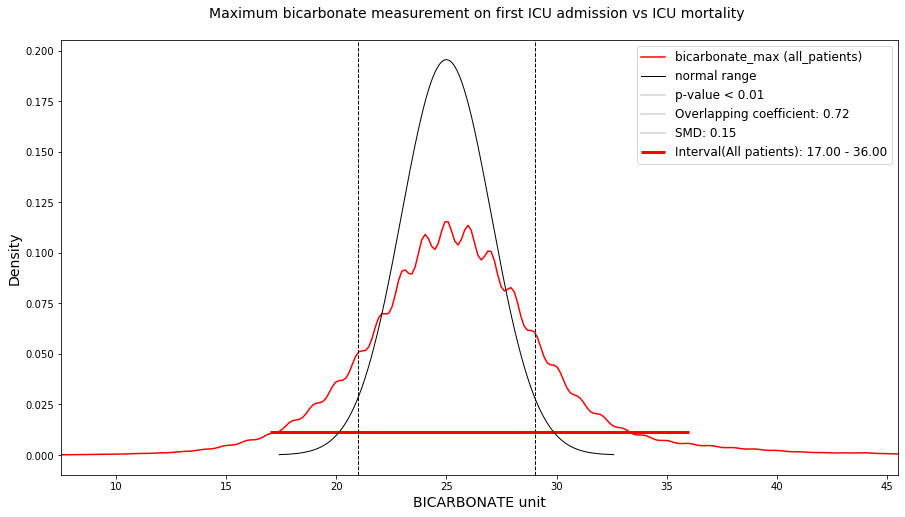

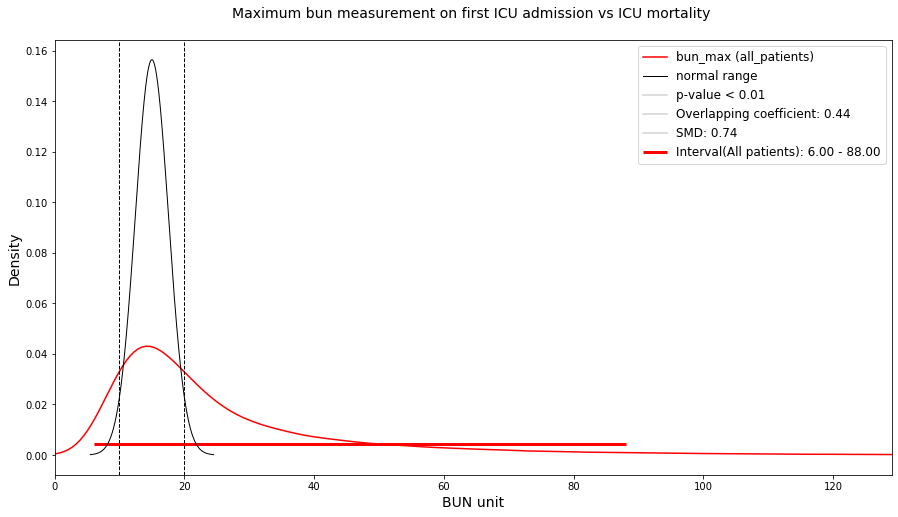

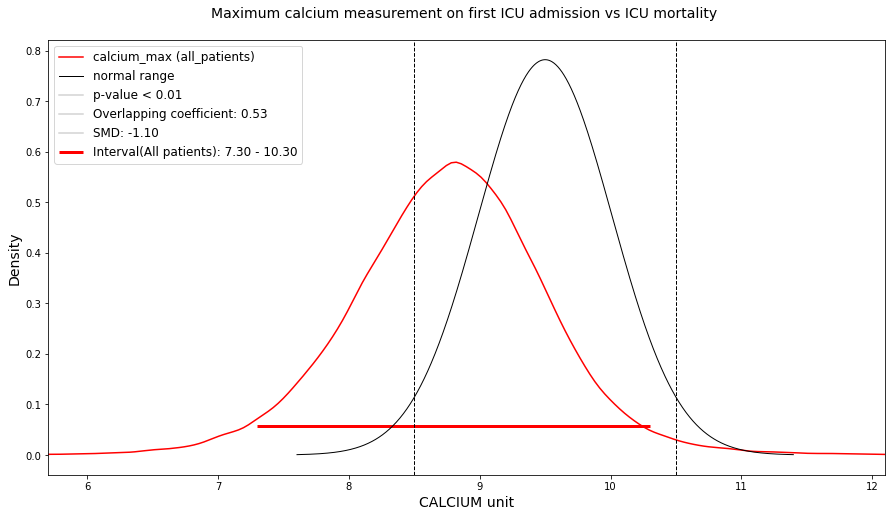

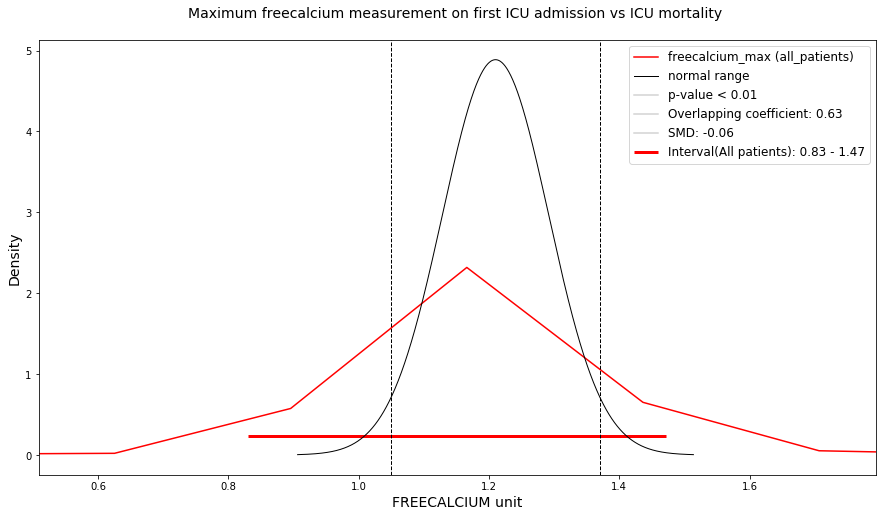

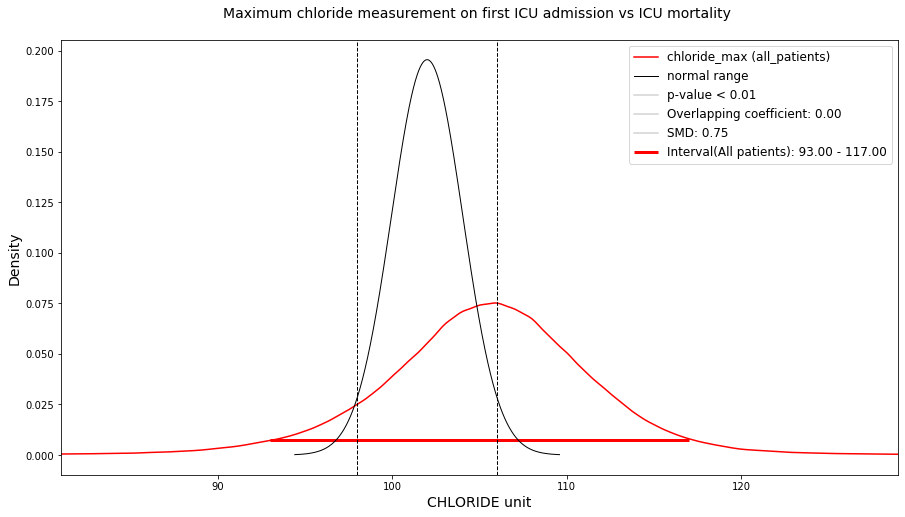

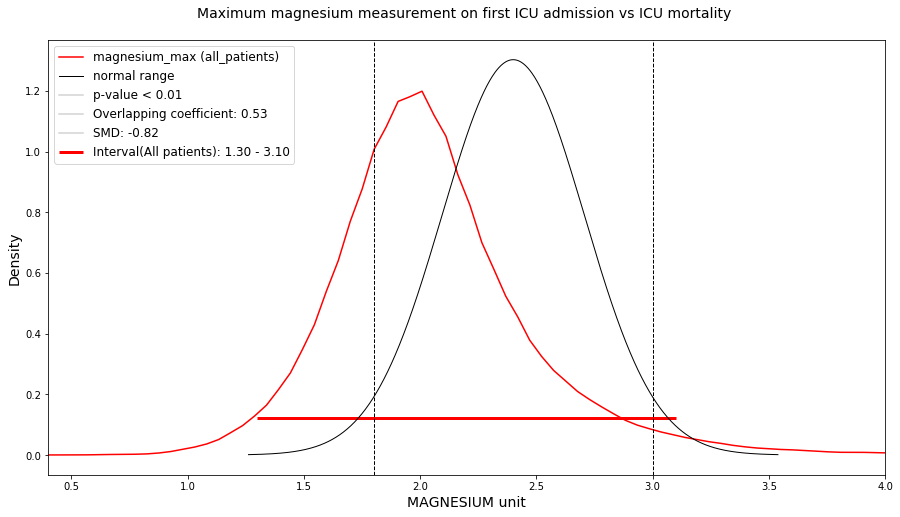

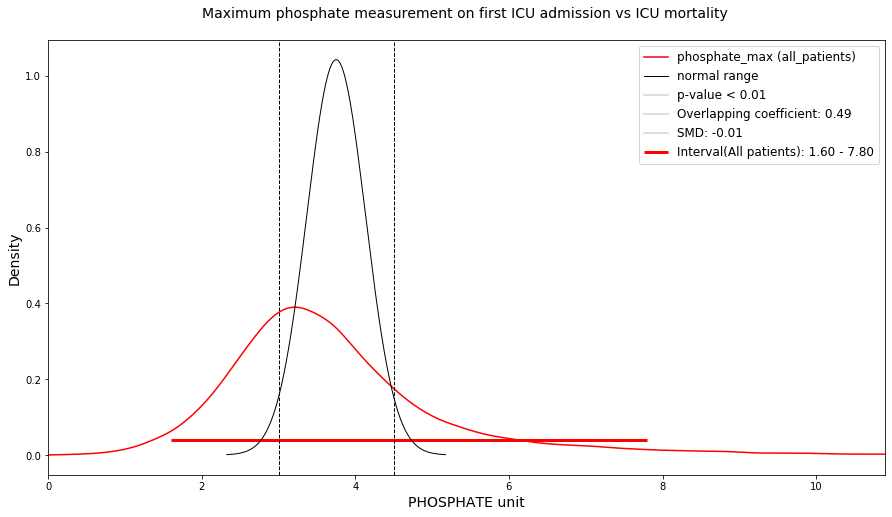

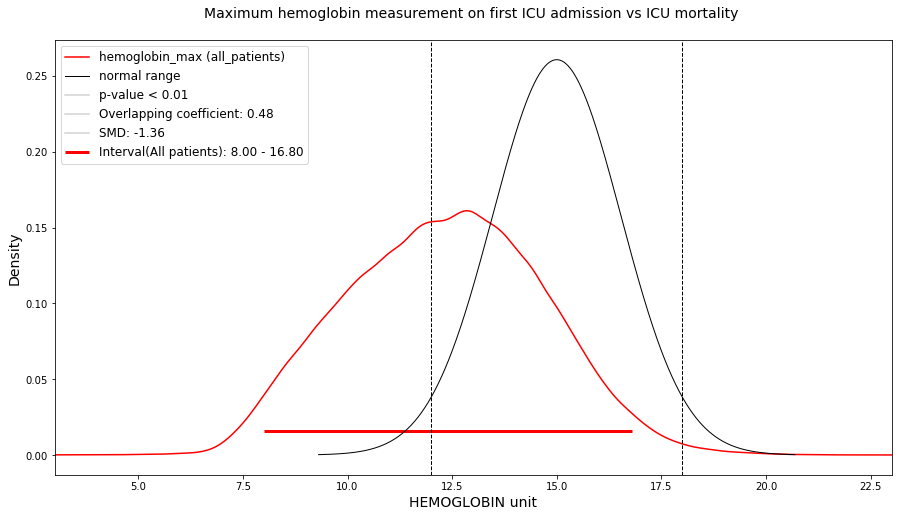

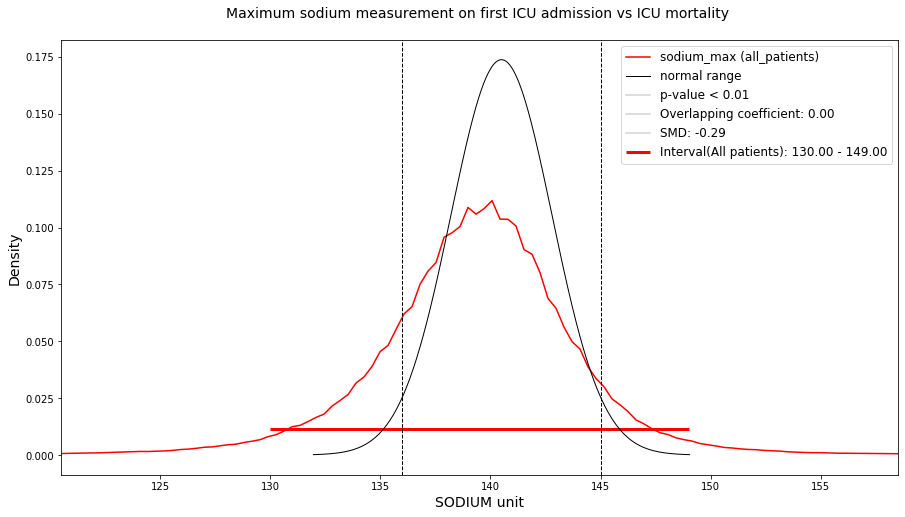

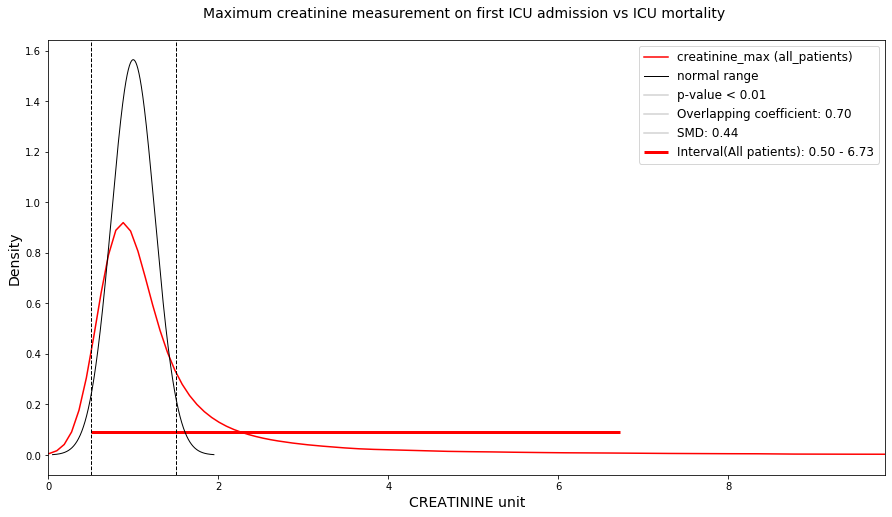

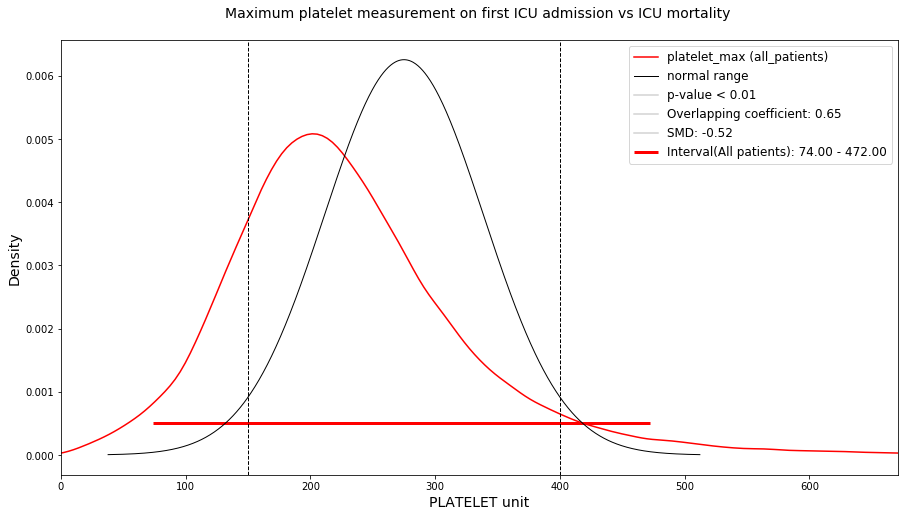

<ipython-input-4-12165610c56e>:14: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(func, -np.inf , np.inf)


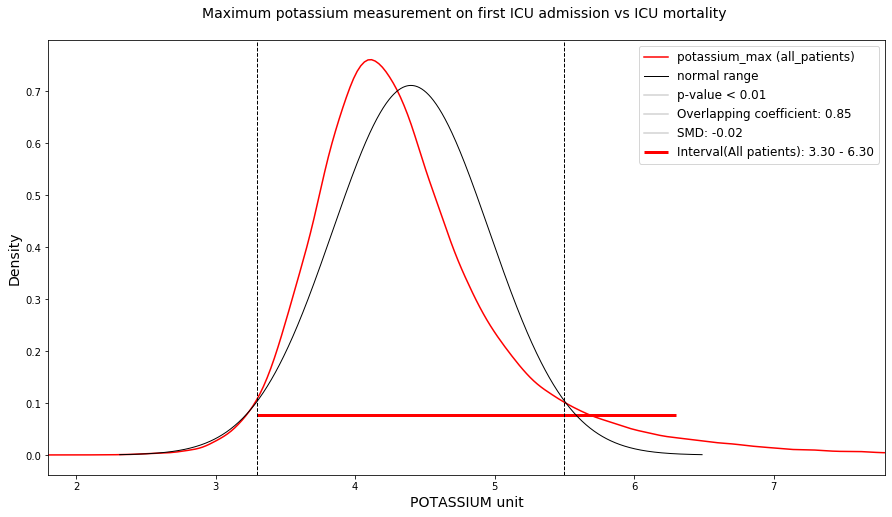

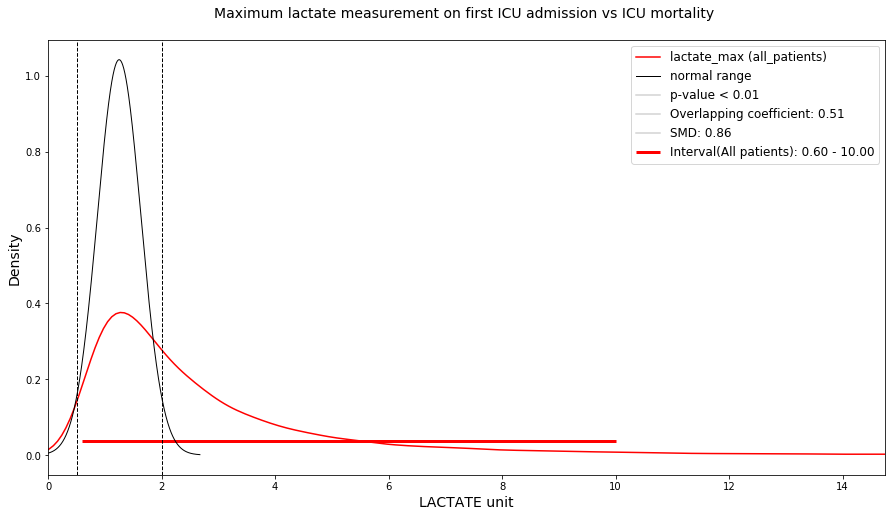

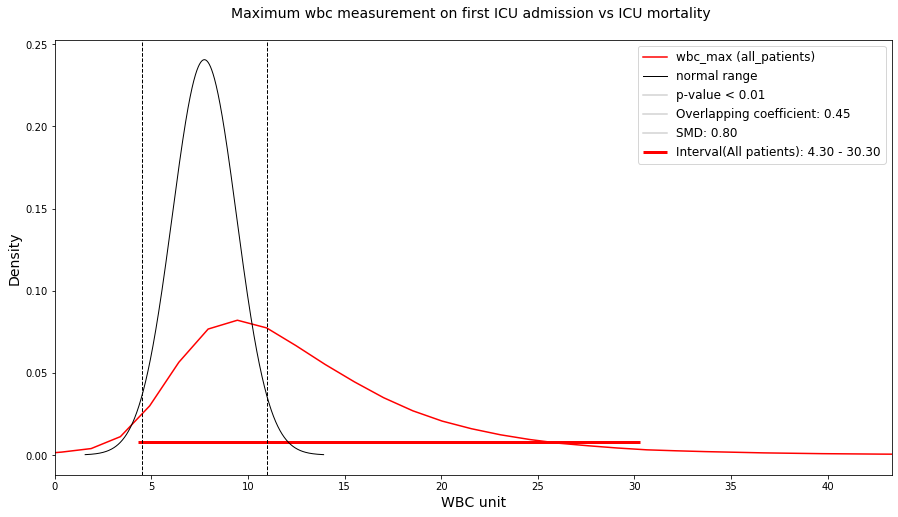

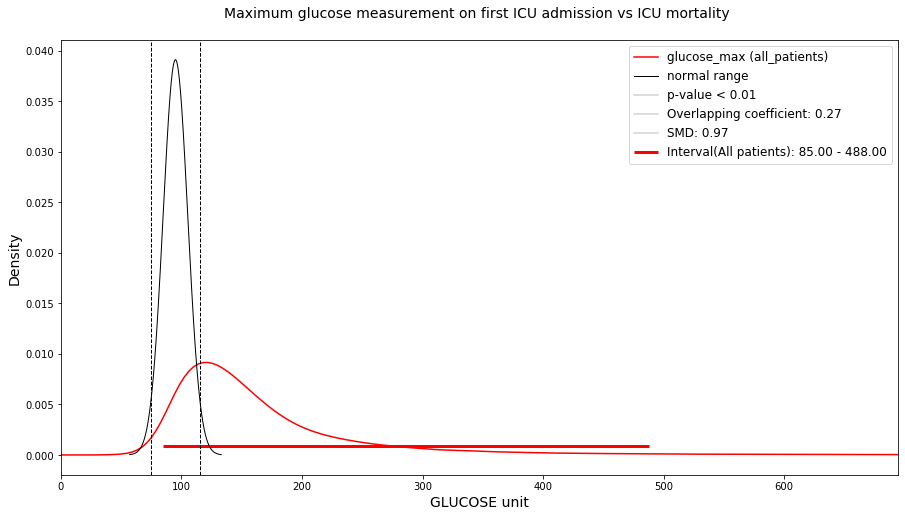

In [6]:
#MAX

for i, u in iter(lab_unit.items()):
    
    
    
    fig, ax = plt.subplots(figsize=(15,8))
    
    #plot best out come dist
    n_surv = surv_data[i.lower() + '_max'].dropna().count()
    n_all = data[i.lower() + '_max'].dropna().count()
    quarter = n_surv /4
    quarter = int(quarter)
    cond = data.mort_icu == 0
    all_patients = surv_data.sort_values(by=['los'])[i.lower()+'_max'].dropna()
    
    [q1, q2] = all_patients.quantile(q = [0.025,0.975])
    
    #best_group = best_group[best_group > q1]
    #best_group = best_group[best_group < q2]

    #range for x and y
    plot_range = [min(q1,lab_ranges[i][0]),max(q2,lab_ranges[i][1])]
    diff = plot_range[1] - plot_range[0]
    #plt.xlim(max(plot_range[0] - 0.5*diff, 0), plot_range[1] + 0.5*diff)
    
    all_patients.plot.kde(color='r', label=i.lower()+'_max (all_patients)', xlim= (max(plot_range[0] - 0.5*diff, 0), plot_range[1] + 0.5*diff))
    
    xs = np.linspace(plot_range[0], plot_range[1], 600)
    density = gaussian_kde(all_patients)
    ys = density(xs)
    index = np.argmax(ys)
    maxy = ys[index]
  
    #plot best outcome interval
    #interval line
    plt.hlines(y=0.1*maxy, xmin = q1, xmax = q2, linewidth=3, linestyle='-', color='r', label='Interval(All patients): {} - {}'.format(format(q1,'.2f'), format(q2,'.2f')))
    
    # plot normal range 
    plt.axvline(x=lab_ranges[i][0], linewidth=1, linestyle='--', color='k')
    plt.axvline(x=lab_ranges[i][1], linewidth=1, linestyle='--', color='k')
    
    
    # plot normal distribution with normal range
    norm_dist = ResumeNorm(lab_ranges[i][0], lab_ranges[i][1])
    x = np.linspace(norm_dist.ppf(0.0001),norm_dist.ppf(0.9999), 1000)
    ax.plot(x, norm_dist.pdf(x), 'k-',#color 'r-' red 'k-' black
            lw=1,#linewidth
            alpha=1,#RGBA transparency
            linestyle='-',
            label='normal range')
    ax.legend(loc='best', frameon=False)
    
    #MannWhitney test
    norm_sample = norm_dist.rvs(size=n_all, random_state=20200620)
    t_stat, p_val = mannwhitneyu(norm_sample, all_patients)
    
    #standardized mean difference
    smd = cohen_d(all_patients, norm_sample)
        
    #overlapping parameter
    all_patients_dist = gaussian_kde(all_patients)
    ovl = OverlapParam(all_patients_dist, norm_dist)
        
    if p_val < 0.01:
        plt.plot([], label='p-value < 0.01', color='lightgrey')
    else:
        plt.plot([], label='p-value: {}'.format(format(p_val, '.2f')), color='lightgrey')
    plt.plot([], label='Overlapping coefficient: {}'.format(format(max(ovl), '.2f')), color='lightgrey')
    plt.plot([], label='SMD: {}'.format(format(smd, '.2f')), color='lightgrey')
    
    plt.title('Maximum {} measurement on first ICU admission '.format(i.lower()) +
                   'vs ICU mortality \n', fontsize=14)
    plt.xlabel(i + ' ' + 'unit', fontsize=14)
    plt.ylabel("Density", fontsize=14)
    plt.legend(fontsize=12)
    plt.savefig("eicu_figure/2group/all_patients/ALL_{}_MAX.png".format(i))
    plt.show()

In [ ]:
#